<a href="https://colab.research.google.com/github/ayulockin/LossLandscape/blob/master/SmallCNN_Val_Acc_Ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setups, Imports and Installations

In [1]:
## This is so that I can save my models.
from google.colab import drive
drive.mount('gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


In [2]:
%%capture
!pip install wandb

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import resnet50

In [19]:
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"

import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

import seaborn as sns
sns.set()

from tqdm.notebook import tqdm_notebook
from sklearn.manifold import TSNE

from sklearn.metrics import accuracy_score

In [5]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Get Trained Models

(For now I am using models trained from SmallCNN.)

In [11]:
ROOT_PATH = 'gdrive/My Drive/LossLandscape/'
## SmallCNN models with different initialization(total 10 models)
MODEL_PATH = ROOT_PATH+'IndependentSolutions/'

In [13]:
model_ckpts = os.listdir(MODEL_PATH)

print(len(model_ckpts))

10


# Get Dataset and Prepare

#### CIFAR-10

In [9]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train = y_train.flatten()
y_test = y_test.flatten()

CLASS_NAMES = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


#### Dataloader

In [10]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128
IMG_SHAPE = 32

testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

def preprocess_image(image, label):
  img = tf.cast(image, tf.float32)
  img = img/255.

  return img, label

testloader = (
    testloader
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Deep Ensemble 

In [15]:
# Choose a single model randomly and load it up
model_ckpt = model_ckpts[int(np.random.choice(len(model_ckpts), 1))]
single_model = tf.keras.models.load_model(MODEL_PATH + model_ckpt)

# Evaluate it
accuracy_single_model = single_model.evaluate(testloader)[1] * 100
accuracy_single_model

79/79 [==============================] - 3s 43ms/step - loss: 0.9625 - accuracy: 0.6600


66.00000262260437

In [16]:
# Create list to models with different solutions
members = [tf.keras.models.load_model(MODEL_PATH + model_ckpts[i]) 
                            for i in range(len(model_ckpts))]
len(members)

10

Reference: https://machinelearningmastery.com/model-averaging-ensemble-for-deep-learning-neural-networks/

In [17]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members):
	# make predictions
	yhats = [model.predict(x_test/255.) for model in members]
	yhats = np.array(yhats)
	# sum across ensemble members
	summed = np.sum(yhats, axis=0)
	# argmax across classes
	result = np.argmax(summed, axis=1)
	return result
 
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members):
    accuracy_list = []
    for n_members in tqdm_notebook(range(2, 12, 2)):
        # select a subset of members
        subset = members[:n_members]
        print(len(subset))
        # make prediction
        yhat = ensemble_predictions(subset)
        # calculate accuracy
        accuracy_list.append(100*accuracy_score(y_test, yhat))

    return accuracy_list

In [20]:
# Run the ensembles
accuracy_list = evaluate_n_members(members)

2
4
6
8
10



In [21]:
accuracy_list.insert(0, accuracy_single_model)
rng = [i for i in range(0, 12, 2)]

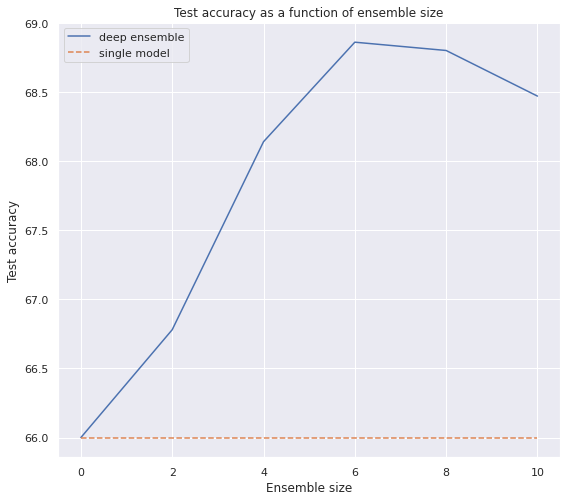

In [28]:
plt.figure(figsize=(9,8))
plt.plot(rng, accuracy_list, label='deep ensemble')
plt.plot(rng, [accuracy_single_model]*len(rng), '--', label='single model')
plt.title("Test accuracy as a function of ensemble size")
plt.xlabel("Ensemble size")
plt.ylabel("Test accuracy")
plt.legend();
plt.savefig('ensemble_func.png')

In [29]:
wandb.init(entity='authors', project='loss-landscape', id='smallcnn_ensemble')
wandb.log({'ensemble_function_small': wandb.Image('ensemble_func.png')})